In [0]:
#cd /content/drive/My Drive/Phone_detection
#!rm -rf /content/Phone_detection2
del zip

In [0]:
from zipfile import ZipFile
file_name='/content/Phone_detection2.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
%cd /content/Phone_detection2/data
!ls

/content/Phone_detection2/data
Annotations  Images


In [0]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}

# Select a model in `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'


In [0]:
%cd /content/Phone_detection2/data
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 400/2000 labels (20% of the labels) to the testing dir: `test_labels`
!ls Annotations/* | sort -R | head -70 | xargs -I{} mv {} test_labels/


# Moves the rest of labels '1600' labels to the training dir: `train_labels`
!ls Annotations/* | xargs -I{} mv {} train_labels/


/content/Phone_detection2/data


In [0]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

In [0]:
%tensorflow_version 1.15
%numpy_version 1.16

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


UsageError: Line magic function `%numpy_version` not found.


In [0]:
!pip install numpy==1.16.0
import numpy as np
np.__version__

'1.16.0'

In [0]:
print(tf.__version__)

1.15.2


In [0]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

In [0]:
#cd /content/drive/My\ Drive/Phone_detection/data
#!rm -rf /content/Phone_detection2/data/test_labels
#!rm -rf /content/Phone_detection2/data/train_labels

In [0]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [0]:
%cd /content/Phone_detection2

/content/Phone_detection2


In [0]:
ls

data/


In [0]:
!git clone --q https://github.com/tensorflow/models.git

In [0]:
cd /content/Phone_detection2/models/research

/content/Phone_detection2/models/research


In [0]:
%cd /content/Phone_detection2/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/Phone_detection2/models/research/:/content/Phone_detection2/models/research/slim/'

/content/Phone_detection2/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [0]:
!python3 object_detection/builders/model_builder_test.py

In [0]:
#adjusted from: https://github.com/datitran/raccoon_dataset
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 
data_base_url = '/content/Phone_detection2/data/'

#location of images
image_dir = data_base_url +'Images/'

def class_text_to_int(row_label):
  if row_label == 'phone':
    return 1
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'jpg'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(data_base_url + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))

Successfully created the TFRecords: /content/Phone_detection2/data/train_labels.record
Successfully created the TFRecords: /content/Phone_detection2/data/test_labels.record


In [0]:

# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}

# Select a model in `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'


In [0]:
%cd /content/Phone_detection2/models/research

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/Phone_detection2/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/Phone_detection2/models/research


In [0]:
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/Phone_detection2/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K May 16 06:08 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [0]:
#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/Phone_detection2/models/research/object_detection/samples/configs/"

#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/content/Phone_detection2/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config'

In [0]:
%%writefile {model_pipline}
model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    # all images will be resized to the below W x H.
    image_resizer { 
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        #use_dropout: false
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000 
        iou_threshold: 0.95
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        
        #adjust this to the max number of objects per class. 
        # ex, in my case, i have one pistol in most of the images.
        # . there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 16
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 16 # training batch size
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.003
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }

  #the path to the pretrained model. 
  fine_tune_checkpoint: "/content/Phone_detection2/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000 
  

  #data augmentaion is done here, you can remove or add more.
  # They will help the model generalize but the training time will increase greatly by using more data augmentation.
  # Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
  
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/content/Phone_detection2/data/train_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/Phone_detection2/data/label_map.pbtxt"
}

eval_config: {
  # the number of images in your "testing" data (was 600 but we removed one above :) )
  num_examples: 100
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20

  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
      
    #path to the testing TFRecord
    input_path: "/content/Phone_detection2/data/test_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/Phone_detection2/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /content/Phone_detection2/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [0]:
%cd /content
model_dir = 'training2/'

/content


In [0]:
ls

Phone_detection2/  Phone_detection2.zip  sample_data/


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-16 06:06:07--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.234.238.166, 34.228.174.189, 35.168.162.120, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.234.238.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  5.36MB/s    in 2.4s    

2020-05-16 06:06:10 (5.36 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://60634503.ngrok.io


In [0]:
!python3 /content/Phone_detection2/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \



W0516 06:09:16.817795 139875560646528 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/utils/config_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0516 06:09:16.821204 139875560646528 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/model_lib.py:685: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0516 06:09:16.821348 139875560646528 model_lib.py:686] Forced number of epochs for all eval validations to be 1.

W0516 06:09:16.821494 139875560646528 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/utils/config_util.py:523: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Maybe overwriting train_steps: None
I0516 06:09:16.821588 139875560646528 config_util.py:523] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting

In [0]:
#the location where the exported model will be saved in.
output_directory = '/content/generatedmodel'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /content/Phone_detection2/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training2/model.ckpt-14759


W0516 09:36:08.989438 139752785438592 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0516 09:36:08.996305 139752785438592 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/exporter.py:419: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0516 09:36:08.996599 139752785438592 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/exporter.py:138: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0516 09:36:09.029237 139752785438592 module_wrapper.py:139] From /content/Phone_detection2/models/research/object_detection/core/preprocessor.py:3030: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0516 09:36:09.053458 139752785438592 module

In [0]:
files.download(output_directory + '/frozen_inference_graph.pb')
files.download(DATA_BASE_PATH + '/label_map.pbtxt')

NameError: ignored

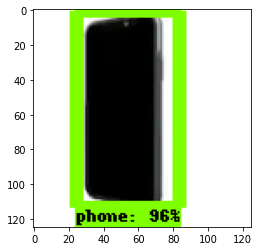

In [50]:
# Write Python3 code here 
import os 
import cv2 
import numpy as np 
import tensorflow as tf 
import sys 
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install utils
# This is needed since the notebook is stored in the object_detection folder. 
sys.path.append("..") 

# Import utilites 
from content.Phone_detection2.models.research.object_detection.utils import label_map_util 
from content.Phone_detection2.models.research.object_detection.utils import visualization_utils as vis_util 

# Name of the directory containing the object detection module we're using 
MODEL_NAME = '/content/generatedmodel' # The path to the directory where frozen_inference_graph is stored. 
IMAGE_NAME = '/content/Phone_detection2/data/Images/01bfc6a5c53e5086.jpg' # The path to the image in which the object has to be detected. 

# Grab path to current working directory 
CWD_PATH = os.getcwd() 

# Path to frozen detection graph .pb file, which contains the model that is used 
# for object detection. 
PATH_TO_CKPT = '/content/generatedmodel/frozen_inference_graph.pb' 

# Path to label map file 
PATH_TO_LABELS = '/content/Phone_detection2/data/label_map.pbtxt'

# Path to image 
PATH_TO_IMAGE = '/content/image6.jpg' 

# Number of classes the object detector can identify 
NUM_CLASSES = 1

# Load the label map. 
# Label maps map indices to category names, so that when our convolution 
# network predicts `5`, we know that this corresponds to `king`. 
# Here we use internal utility functions, but anything that returns a 
# dictionary mapping integers to appropriate string labels would be fine 
label_map = label_map_util.load_labelmap(PATH_TO_LABELS) 
categories = label_map_util.convert_label_map_to_categories( 
		label_map, max_num_classes = NUM_CLASSES, use_display_name = True) 
category_index = label_map_util.create_category_index(categories) 

# Load the Tensorflow model into memory. 
detection_graph = tf.Graph() 
with detection_graph.as_default(): 
	od_graph_def = tf.GraphDef() 
	with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid: 
		serialized_graph = fid.read() 
		od_graph_def.ParseFromString(serialized_graph) 
		tf.import_graph_def(od_graph_def, name ='') 

	sess = tf.Session(graph = detection_graph) 

# Define input and output tensors (i.e. data) for the object detection classifier 

# Input tensor is the image 
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0') 

# Output tensors are the detection boxes, scores, and classes 
# Each box represents a part of the image where a particular object was detected 
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0') 

# Each score represents level of confidence for each of the objects. 
# The score is shown on the result image, together with the class label. 
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0') 
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0') 

# Number of objects detected 
num_detections = detection_graph.get_tensor_by_name('num_detections:0') 

# Load image using OpenCV and 
# expand image dimensions to have shape: [1, None, None, 3] 
# i.e. a single-column array, where each item in the column has the pixel RGB value 
image = cv2.imread(PATH_TO_IMAGE) 
image_expanded = np.expand_dims(image, axis = 0) 

# Perform the actual detection by running the model with the image as input 
(boxes, scores, classes, num) = sess.run( 
	[detection_boxes, detection_scores, detection_classes, num_detections], 
	feed_dict ={image_tensor: image_expanded}) 

# Draw the results of the detection (aka 'visualize the results') 

vis_util.visualize_boxes_and_labels_on_image_array( 
	image, 
	np.squeeze(boxes), 
	np.squeeze(classes).astype(np.int32), 
	np.squeeze(scores), 
	category_index, 
	use_normalized_coordinates = True, 
	line_thickness = 8, 
	min_score_thresh = 0.60) 

# All the results have been drawn on the image. Now display the image. 
plt.imshow(image) 
plt.show()
# Press any key to close the image 
#cv2.waitKey(0) 

# Clean up 
#cv2.destroyAllWindows() 


In [0]:
import matplotlib.pyplot as plt

In [0]:
sys.path.insert(0, '/content/Phone_detection2/models/research/object_detection')

In [0]:
#!/usr/bin/env python
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

if __name__ == '__main__':
    zipf = zipfile.ZipFile('Model1.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir('Phone_detection2', zipf)
    zipf.close()